<a href="https://colab.research.google.com/github/jpatrickweller/Data_Challenges/blob/main/MA_model_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
register_matplotlib_converters()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Generate some data for the MA model. As I understand it, not much pure MA data exists in the wild, so I'm just generating some.

yt = 50 + 0.4et-1 + 0.3et-2 + et


et ~ N(0,1)

In [3]:
errors = np.random.normal(0, 1, 400)

In [4]:
date_index = pd.date_range(start='9/1/2019', end='1/1/2020')

In [5]:
mu = 50
s = []
for t in range(1, len(date_index)+1):
    s.append(mu + 0.4*errors[t-1] + 0.3*errors[t-2] + errors[t])

In [6]:
s = pd.Series(s, date_index)
s = s.asfreq(pd.infer_freq(s.index))

s

2019-09-01    51.126856
2019-09-02    49.909761
2019-09-03    51.014733
2019-09-04    49.395928
2019-09-05    50.115282
                ...    
2019-12-28    49.290122
2019-12-29    49.205598
2019-12-30    50.162528
2019-12-31    49.493972
2020-01-01    49.366985
Freq: D, Length: 123, dtype: float64

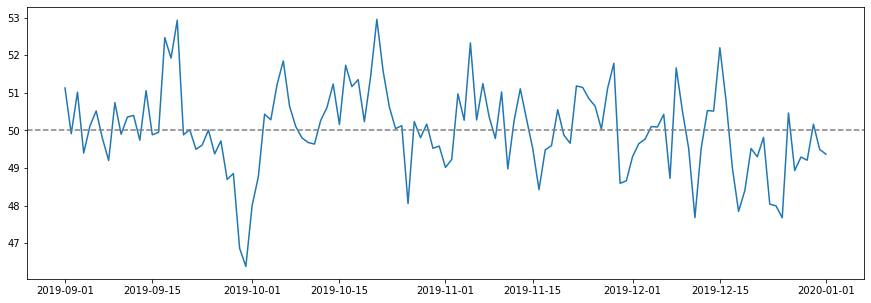

In [7]:
# Plot!

plt.figure(figsize=(15,5))
plt.plot(s)
plt.axhline(mu, linestyle='--', c='grey')
plt.show()

In [8]:
def calc_corr(series, lag):
    return pearsonr(series[:-lag], series[lag:])[0]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


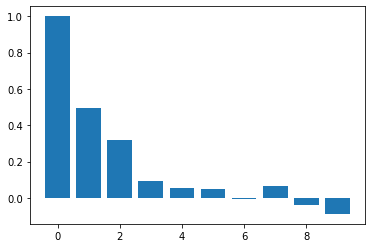

In [9]:
# Look at the ACF for significant MA components

acf_vals = acf(s)
num_lags = 10
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.show()

# MA(2) is probably approriate

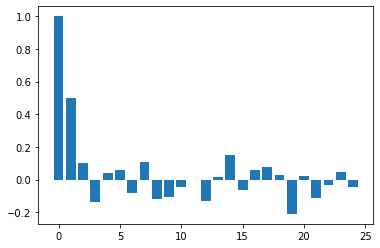

In [10]:
# Look at the pacf for relevant AR components

pacf_vals = pacf(s)
num_lags = 25
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.show()

## Train / test split

In [14]:
# make training and testing sets

train_end = dt.datetime(2019,12,30)
test_end = dt.datetime(2020,1,1)

train_data = s[:train_end]
test_data = s[train_end+dt.timedelta(days=1):test_end] 
# Small aside here. I'm adding 1 day here bc slicing like this 
# (as with .loc) is inclusive. Only .iloc is exclusive. 
# Why this behaivor?? In general, if the position is 
# important, you want to use exclusive beahvior (as standard in python). 
# If labels are important, you want inclusive behavior.

display(train_data)
display(test_data)

2019-09-01    51.126856
2019-09-02    49.909761
2019-09-03    51.014733
2019-09-04    49.395928
2019-09-05    50.115282
                ...    
2019-12-26    50.461778
2019-12-27    48.931623
2019-12-28    49.290122
2019-12-29    49.205598
2019-12-30    50.162528
Freq: D, Length: 121, dtype: float64

2019-12-31    49.493972
2020-01-01    49.366985
Freq: D, dtype: float64

## Fit the model!

In [15]:
# create the model
model = ARIMA(train_data, order=(0,0,2))

In [16]:
# fit the model
model_fit = model.fit()

In [17]:
# assess the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  121
Model:                     ARMA(0, 2)   Log Likelihood                -169.215
Method:                       css-mle   S.D. of innovations              0.978
Date:                Mon, 01 Mar 2021   AIC                            346.430
Time:                        19:39:39   BIC                            357.614
Sample:                    09-01-2019   HQIC                           350.972
                         - 12-30-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0334      0.161    309.840      0.000      49.717      50.350
ma.L1.y        0.4675      0.087      5.371      0.000       0.297       0.638
ma.L2.y        0.3582      0.084      4.252      0.000       0.193       0.523
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.6526           -1.5381j            1.6709           -0.3139
MA.2           -0.6526           +1.5381j            1.6709            0.3139
-----------------------------------------------------------------------------
"""

## Predictions!

In [18]:
# pull out the start and end dates
pred_start = test_data.index[0]
pred_end = test_data.index[-1]

In [19]:
# Make predictions
predictions = model_fit.predict(start=pred_start, end=pred_end)

In [20]:
# Get the residuals
residuals = test_data - predictions

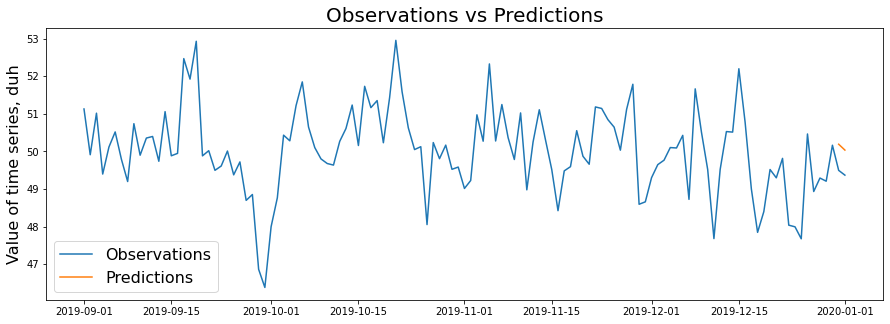

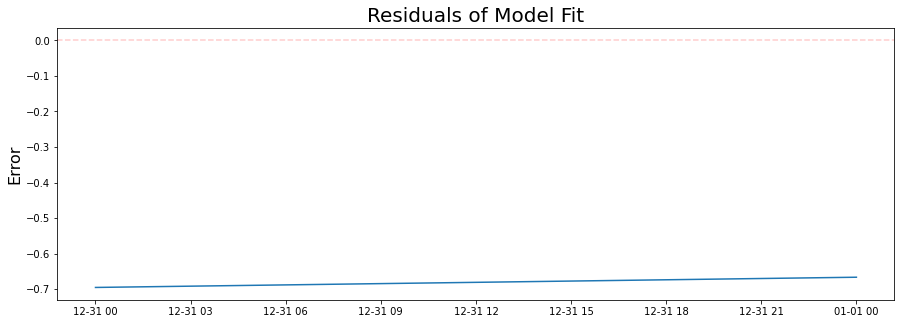

Mean absolute percent error: 0.0138
Mean squared error = 0.46


In [51]:
# Plot the predictions!

def plot_predictions(observations, predictions):
    plt.figure(figsize=(15,5))
    plt.plot(observations, label='Observations')
    plt.plot(predictions, label='Predictions')
    plt.legend(loc='best', fontsize=16)
    plt.title('Observations vs Predictions', fontsize=20)
    plt.ylabel('Value of time series, duh', fontsize=16)
    plt.show()

def plot_residuals(residuals, observations):
    plt.figure(figsize=(15,5))
    plt.plot(residuals)
    plt.title('Residuals of Model Fit', fontsize=20)
    plt.ylabel('Error', fontsize=16)
    plt.axhline(y=0, linestyle='--', alpha=.2 , color='r')
    plt.show()

    mse = (residuals.values**2).mean().round(2)
    mpe = round(np.mean(abs(residuals/observations)),4)
    print(f"Mean absolute percent error: {mpe}")
    print(f"Mean squared error = {mse}")

plot_predictions(s, predictions)
plot_residuals(residuals, test_data)

0.46